<a href="https://colab.research.google.com/github/fsclsnow/AML/blob/master/AML_Project5_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 - Team 2

In this project, we work on the data set that has been prepared to analyze factors relating to readmission as well as other outcomes pertaining to patients with diabetes.

Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

1.   It is an inpatient encounter (a hospital admission).
2.   It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3.   The length of stay was at least 1 day and at most 14 days.
4.   Laboratory tests were performed during the encounter.
5.   Medications were administered during the encounter.
6.   The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

The following instructions have been performed:
1.  Perform data scrubbing to deal with missing data, and then scale the data. 
2.  Find out which features have most influence on patients with diabetes or being readmitted, e.g., age, race, weight, blood pressure, etc.
3.  Use RF and SVM (linear as well as nonlinear kernels , as necessary) to learn classification of diabetic patients and those being readmitted.
4.  If using a LinearSVC, also use SVC and SGDClassifier to see if you can get them to roughly produce the same model.
5.  Calculate and present performance parameters (e.g. accuracy, etc.) of each model using appropriate graphs such as bar charts.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# Download the data
import urllib
import os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fsclsnow/AML/master/"
Diabetic_PATH = os.path.join("Data")
Diabetic_URL = DOWNLOAD_ROOT + "Data/diabetic_data.csv"

In [0]:
import pandas as pd

def load_dia_data(dia_path=Diabetic_PATH):
    csv_path = os.path.join(DOWNLOAD_ROOT, dia_path, "diabetic_data.csv")
    return pd.read_csv(csv_path)

In [0]:
diabetic = load_dia_data()
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

# Data Scrubbing

Weight attribute was considered to be too
sparse and it was not included in further analysis. 

Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome.

Medical specialty attribute has over 50% missing data.

Therefore, there three attributes is dropped.

Reference: http://downloads.hindawi.com/journals/bmri/2014/781670.pdf

In [0]:
diabetic = diabetic.drop("weight", axis=1)
diabetic = diabetic.drop("payer_code", axis=1)
diabetic = diabetic.drop("medical_specialty", axis=1)


In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null object
diag_2                      101766 non-null object
diag_3                      101766

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

Reference: http://downloads.hindawi.com/journals/bmri/2014/781670.pdf

In [0]:
diabetic = diabetic.replace({"readmitted": ">30"}, "No")
diabetic = diabetic.replace({"readmitted": "<30"}, "Yes")


In [0]:
diabetic["readmitted"][:15]

0      NO
1      No
2      NO
3      NO
4      NO
5      No
6      NO
7      No
8      NO
9      NO
10     No
11    Yes
12    Yes
13     NO
14     No
Name: readmitted, dtype: object

We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days.

In [0]:
diabetic = diabetic.drop_duplicates(subset=["patient_nbr"])

In [0]:
diabetic["encounter_id"].count()

71518

Now wo have 71518 distinctive patients records without same patients that have multiple visit records.

In [0]:
diabetic["race"][:20]

0           Caucasian
1           Caucasian
2     AfricanAmerican
3           Caucasian
4           Caucasian
5           Caucasian
6           Caucasian
7           Caucasian
8           Caucasian
9           Caucasian
10    AfricanAmerican
11    AfricanAmerican
12          Caucasian
13          Caucasian
14    AfricanAmerican
15    AfricanAmerican
16    AfricanAmerican
17          Caucasian
18    AfricanAmerican
19                  ?
Name: race, dtype: object

Columns "Race" have 2% missing data, it's not a lot, therefore they are filled with "Other".

In [0]:
diabetic["race"].replace("?","Other",inplace = True)

In [0]:
diabetic["race"][:20]

0           Caucasian
1           Caucasian
2     AfricanAmerican
3           Caucasian
4           Caucasian
5           Caucasian
6           Caucasian
7           Caucasian
8           Caucasian
9           Caucasian
10    AfricanAmerican
11    AfricanAmerican
12          Caucasian
13          Caucasian
14    AfricanAmerican
15    AfricanAmerican
16    AfricanAmerican
17          Caucasian
18    AfricanAmerican
19              Other
Name: race, dtype: object

Then we'll need to make a desicion on other columns which has small amount of missing data, including "diag_1" <0.1%, "diag_2" 0.3%, "diag_3" 1.3%.

Since this project is only targeting the diabetes here which has value as 250.xx. All values other than this tag will be taged as 'No' while all diagnose as diabetes will be taged as 'Yes'. 

In [0]:
diabetic["diag_1"][0:10]

0    250.83
1       276
2       648
3         8
4       197
5       414
6       414
7       428
8       398
9       434
Name: diag_1, dtype: object

In [0]:
diabetic["diag_1"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_1"].replace("^250.*","Yes",inplace = True,regex=True)

In [0]:
diabetic["diag_1"][0:10]

0    Yes
1     No
2     No
3     No
4     No
5     No
6     No
7     No
8     No
9     No
Name: diag_1, dtype: object

Let's do the same on 'diag_2' and 'diag_3'.

In [0]:
diabetic["diag_2"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_2"].replace("^250.*","Yes",inplace = True,regex=True)
diabetic["diag_3"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_3"].replace("^250.*","Yes",inplace = True,regex=True)

In [0]:
diabetic["diag_2"][0:10]

0     No
1    Yes
2    Yes
3    Yes
4     No
5     No
6     No
7     No
8     No
9     No
Name: diag_2, dtype: object

Now, all missing data have been handled. Since there are three diagnoses in the columns, here we unite these three columns into 1 when diagnose of diabetes exist in one of the three.

In [0]:
diabetic["Cons_diag"] = 0

Value "1" means the patient was once diagnosed for diabetes, whereas "0" no diabete diagnosed.

In [0]:
diabetic["Cons_diag"][diabetic.diag_1=="Yes"] = 1
diabetic["Cons_diag"][diabetic.diag_2=="Yes"] = 1
diabetic["Cons_diag"][diabetic.diag_3=="Yes"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

In [0]:
diabetic["Cons_diag"][:20]

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     0
9     0
10    1
11    0
12    1
13    0
14    0
15    0
16    0
17    1
18    0
19    0
Name: Cons_diag, dtype: int64

In [0]:
diabetic["Cons_diag"].value_counts()

0    43713
1    27805
Name: Cons_diag, dtype: int64

Now we can drop the colums: "diag_1", "diag_2" and "diag_3"

In [0]:
diabetic = diabetic.drop("diag_1",axis=1)
diabetic = diabetic.drop("diag_2",axis=1)
diabetic = diabetic.drop("diag_3",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                71518 non-null int64
patient_nbr                 71518 non-null int64
race                        71518 non-null object
gender                      71518 non-null object
age                         71518 non-null object
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
number_diagnoses            71518 non-null int64
max_glu_serum               71518 non-null object
A1Cresult                   71518 non-null object
met

Similarly, we replace column "readmitted" with a new int64 column. 

Value "1" means readmitted, "0" means not readmitted.

In [0]:
diabetic["re_ad"] = 0

In [0]:
diabetic["re_ad"][diabetic.readmitted=="Yes"] = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
diabetic["re_ad"][:15]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    1
13    0
14    0
Name: re_ad, dtype: int64

In [0]:
diabetic["readmitted"][:15]

0      NO
1      No
2      NO
3      NO
4      NO
5      No
6      NO
7      No
8      NO
9      NO
10     No
11    Yes
12    Yes
13     NO
14     No
Name: readmitted, dtype: object

Then, drop the column "readmitted".

In [0]:
diabetic = diabetic.drop("readmitted",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                71518 non-null int64
patient_nbr                 71518 non-null int64
race                        71518 non-null object
gender                      71518 non-null object
age                         71518 non-null object
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
number_diagnoses            71518 non-null int64
max_glu_serum               71518 non-null object
A1Cresult                   71518 non-null object
met

Consider HbA1c might be highly related to the diagnoses for diabetes, here A1Cresult is transformed into numeric values.

1.   "None"   => 0
2.   "Norm"   => 1
3.   ">7"     => 2
4.   ">8"     => 3



In [0]:
diabetic["HbA1c"] = 0
diabetic["HbA1c"][diabetic.A1Cresult=="Norm"] = 1
diabetic["HbA1c"][diabetic.A1Cresult==">7"] = 2
diabetic["HbA1c"][diabetic.A1Cresult==">8"] = 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic["A1Cresult"][70:100]

70     None
71     None
72     None
73     None
74       >7
75     None
76     None
77     None
78     None
80     None
82     None
83     None
84     None
85     None
86     None
87     None
88     None
89     None
90     None
91     None
92     None
93     None
94     None
95     None
96     None
97     None
98       >8
99     None
100    None
101    None
Name: A1Cresult, dtype: object

In [0]:
diabetic["HbA1c"][70:100]

70     0
71     0
72     0
73     0
74     2
75     0
76     0
77     0
78     0
80     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     3
99     0
100    0
101    0
Name: HbA1c, dtype: int64

Good, data validated, now we drop the column "A1Cresult".

In [0]:
diabetic = diabetic.drop("A1Cresult",axis=1)

# Data Preparation

In [0]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(diabetic, 0.2)
len(train_set)

57215

In [0]:
len(test_set)

14303

Here we did not use 'train_test_split' from sklearn because, two columns were unreasonably missing after this build-in function called.

In [0]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57215 entries, 92452 to 20791
Data columns (total 45 columns):
encounter_id                57215 non-null int64
patient_nbr                 57215 non-null int64
race                        57215 non-null object
gender                      57215 non-null object
age                         57215 non-null object
admission_type_id           57215 non-null int64
discharge_disposition_id    57215 non-null int64
admission_source_id         57215 non-null int64
time_in_hospital            57215 non-null int64
num_lab_procedures          57215 non-null int64
num_procedures              57215 non-null int64
num_medications             57215 non-null int64
number_outpatient           57215 non-null int64
number_emergency            57215 non-null int64
number_inpatient            57215 non-null int64
number_diagnoses            57215 non-null int64
max_glu_serum               57215 non-null object
metformin                   57215 non-null object


Still have 45 columns, good.

Take a further look into the database, there are 16 columns that are numeric. Let's take them out.

In [0]:
diabetic_num = train_set.drop(['race','gender','age', 
                              'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed'],axis=1)

In [0]:
diabetic_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57215 entries, 92452 to 20791
Data columns (total 16 columns):
encounter_id                57215 non-null int64
patient_nbr                 57215 non-null int64
admission_type_id           57215 non-null int64
discharge_disposition_id    57215 non-null int64
admission_source_id         57215 non-null int64
time_in_hospital            57215 non-null int64
num_lab_procedures          57215 non-null int64
num_procedures              57215 non-null int64
num_medications             57215 non-null int64
number_outpatient           57215 non-null int64
number_emergency            57215 non-null int64
number_inpatient            57215 non-null int64
number_diagnoses            57215 non-null int64
Cons_diag                   57215 non-null int64
re_ad                       57215 non-null int64
HbA1c                       57215 non-null int64
dtypes: int64(16)
memory usage: 7.4 MB


In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["Cons_diag"].sort_values(ascending=False)

Cons_diag                   1.000000
HbA1c                       0.121332
admission_type_id           0.035208
number_emergency            0.011058
re_ad                      -0.009619
admission_source_id        -0.024864
number_outpatient          -0.027011
number_inpatient           -0.027463
discharge_disposition_id   -0.034045
num_lab_procedures         -0.068033
num_procedures             -0.092347
patient_nbr                -0.093779
encounter_id               -0.102810
time_in_hospital           -0.134795
num_medications            -0.139743
number_diagnoses           -0.416904
Name: Cons_diag, dtype: float64

From the numeric colums, the most corelated column to diagnosis of diabetes is 'number_diagnoses'.

Saving figure scatter_matrix_plot


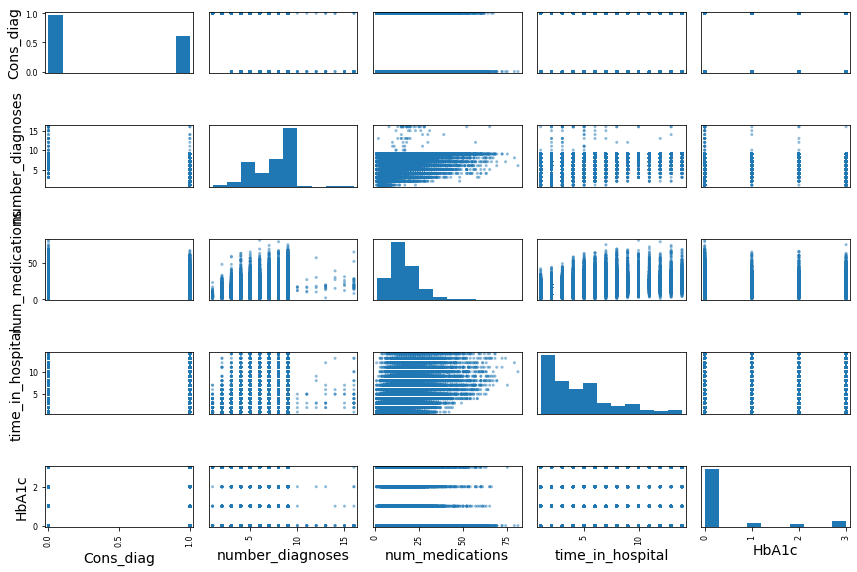

In [0]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["Cons_diag", "number_diagnoses", "num_medications","time_in_hospital","HbA1c"]
scatter_matrix(diabetic_num[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["re_ad"].sort_values(ascending=False)

re_ad                       1.000000
number_inpatient            0.101205
discharge_disposition_id    0.057935
time_in_hospital            0.053720
number_diagnoses            0.040868
num_medications             0.032824
num_lab_procedures          0.028207
number_emergency            0.026778
number_outpatient           0.005574
patient_nbr                 0.005406
admission_source_id         0.004343
admission_type_id           0.003876
num_procedures             -0.005019
HbA1c                      -0.006868
Cons_diag                  -0.009619
encounter_id               -0.049307
Name: re_ad, dtype: float64

From the numeric colums, it seems all these columns have very low corelations with 'readmitted'.

In [0]:
diabetic_train = train_set.drop("Cons_diag", axis=1) # drop labels for training set
diabetic_train = diabetic_train.drop("re_ad", axis=1)
dia_labels_diag = train_set["Cons_diag"].copy()
dia_labels_read = train_set["re_ad"].copy()

Now let's build a pipeline for preprocessing the numerical attributes with scaling:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

diabetic_tr = num_pipeline.fit_transform(diabetic_num)

In [0]:
diabetic_tr

array([[ 1.64636075,  0.56127563, -0.72770604, ...,  1.25718214,
        -0.3138021 ,  2.82091165],
       [-1.00106661, -1.3950704 , -0.72770604, ..., -0.79542969,
        -0.3138021 ,  1.73660165],
       [-0.35994688, -0.78339901, -0.72770604, ..., -0.79542969,
        -0.3138021 , -0.43201837],
       ...,
       [ 0.67580196,  0.10742467, -0.72770604, ...,  1.25718214,
        -0.3138021 ,  0.65229164],
       [-1.49277882, -1.14429881,  2.59374371, ...,  1.25718214,
        -0.3138021 ,  0.65229164],
       [-0.8362165 , -1.31321727,  0.60087386, ...,  1.25718214,
        -0.3138021 ,  2.82091165]])

Next we'll deal with categorical columns.

In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(diabetic_num)
cat_attribs = ['race','gender','age',
                              'max_glu_serum','metformin','repaglinide','nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

dia_prepared = full_pipeline.fit_transform(train_set)

In [0]:
dia_prepared.shape

(57215, 108)

Since all the data has transformed into 2D float array, we are unable to run correlation matrix to seek the most correlated attributes among non-numeric columns.

Now let's do the same on the test data set.

In [0]:
test_num = test_set.drop(['race','gender','age', 
                              'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed'],axis=1)

In [0]:
test_labels_diag = test_set["Cons_diag"].copy()
test_labels_read = test_set["re_ad"].copy()
diabetic_test = test_set.drop("Cons_diag", axis=1) # drop labels for testing set
diabetic_test = diabetic_test.drop("re_ad", axis=1)

In [0]:
test_tr = num_pipeline.fit_transform(test_num)

In [0]:
num_attribs = list(test_num)
cat_attribs = ['race','gender','age',
                              'max_glu_serum','metformin','repaglinide','nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [0]:
test_prepared = full_pipeline.fit_transform(test_set)

In [0]:
test_prepared.shape

(14303, 103)

It is probably the variance of data value of the training set and the testing set causing the difference of column number after transforming all the non-numeric data into numeric data.

In order to avoid discrepancy, let's try taking out more logically irrelevant catogorical columns.

In [0]:
num_attribs = list(diabetic_num)
cat_attribs = ['race','gender','age','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

dia_prepared = full_pipeline.fit_transform(train_set)

In [0]:
diabetic_num.shape

(57215, 16)

In [0]:
dia_prepared.shape

(57215, 38)

In [0]:
num_attribs = list(test_num)
cat_attribs = ['race','gender','age','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

test_prepared = full_pipeline.fit_transform(test_set)

In [0]:
test_num.shape

(14303, 16)

In [0]:
test_prepared.shape

(14303, 37)

Still not working. We observed that after transformation, the training set has 38 columns, while the testing set has 37 columns.

Therefore, we'll manually transform columns "race", "age","gender","change","diabetesMed" into numeric data.

Race is transformed into numeric values.

1.   "Other"               => 0
2.   "Caucasian"           => 1
3.   "AfricanAmerican"     => 2
4.   "Asian"               => 3
5.   "Hispanic"            => 4


In [0]:
diabetic["Race"] = 0
diabetic["Race"][diabetic.race=="Caucasian"] = 1
diabetic["Race"][diabetic.race=="AfricanAmerican"] = 2
diabetic["Race"][diabetic.race=="Asian"] = 3
diabetic["Race"][diabetic.race=="Hispanic"] = 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic = diabetic.drop("race",axis=1)

Gender is transformed into numeric values.

1.   "Unknown/Invalid"  => 0
2.   "Female"           => 1
3.   "Male"             => 2

In [0]:
diabetic["Gender"] = 0
diabetic["Gender"][diabetic.gender=="Female"] = 1
diabetic["Gender"][diabetic.gender=="Male"] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
diabetic = diabetic.drop("gender",axis=1)

Age is transformed into numeric values.

1.   "[0-10)"               => 0
2.   "[10-20)"              => 1
3.   "[20-30)"              => 2
4.   "[30-40)"              => 3
5.   "[40-50)"              => 4
5.   "[50-60)"              => 5
6.   "[60-70)"              => 6
7.   "[70-80)"              => 7
8.   "[80-90)"              => 8
9.   "[90-100)"             => 9

In [0]:
diabetic["Age"] = 0
diabetic["Age"][diabetic.age=="[10-20)"] = 1
diabetic["Age"][diabetic.age=="[20-30)"] = 2
diabetic["Age"][diabetic.age=="[30-40)"] = 3
diabetic["Age"][diabetic.age=="[40-50)"] = 4
diabetic["Age"][diabetic.age=="[50-60)"] = 5
diabetic["Age"][diabetic.age=="[60-70)"] = 6
diabetic["Age"][diabetic.age=="[70-80)"] = 7
diabetic["Age"][diabetic.age=="[80-90)"] = 8
diabetic["Age"][diabetic.age=="[90-100)"] = 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic = diabetic.drop("age",axis=1)

Change is transformed into numeric values.

1.   "Ch"               => 0
2.   "No"               => 1

In [0]:
diabetic["Change"] = 0
diabetic["Change"][diabetic.change=="No"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
diabetic = diabetic.drop("change",axis=1)

DiabetesMed is transformed into numeric values.

1.   "Yes"               => 0
2.   "No"                => 1

In [0]:
diabetic["DiabetesMed"] = 0
diabetic["DiabetesMed"][diabetic.diabetesMed=="No"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
diabetic = diabetic.drop("diabetesMed",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                71518 non-null int64
patient_nbr                 71518 non-null int64
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
number_diagnoses            71518 non-null int64
max_glu_serum               71518 non-null object
metformin                   71518 non-null object
repaglinide                 71518 non-null object
nateglinide                 71518 non-null object
chlorpropamide              71518 non-null object
gli

Now, we can drop all the non-numeric columns.

In [0]:
diabetic_num = diabetic.drop(['max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone'],axis=1)

In [0]:
diabetic_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 21 columns):
encounter_id                71518 non-null int64
patient_nbr                 71518 non-null int64
admission_type_id           71518 non-null int64
discharge_disposition_id    71518 non-null int64
admission_source_id         71518 non-null int64
time_in_hospital            71518 non-null int64
num_lab_procedures          71518 non-null int64
num_procedures              71518 non-null int64
num_medications             71518 non-null int64
number_outpatient           71518 non-null int64
number_emergency            71518 non-null int64
number_inpatient            71518 non-null int64
number_diagnoses            71518 non-null int64
Cons_diag                   71518 non-null int64
re_ad                       71518 non-null int64
HbA1c                       71518 non-null int64
Race                        71518 non-null int64
Gender                      71518 non-null int64
Age     

Let's run the corr-matrix again.

In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["Cons_diag"].sort_values(ascending=False)

Cons_diag                   1.000000
HbA1c                       0.124726
Race                        0.056704
admission_type_id           0.030759
number_emergency            0.008791
Gender                      0.001944
re_ad                      -0.007960
admission_source_id        -0.024060
number_outpatient          -0.027486
number_inpatient           -0.027817
discharge_disposition_id   -0.034008
DiabetesMed                -0.067698
num_lab_procedures         -0.068966
Change                     -0.069543
num_procedures             -0.095123
patient_nbr                -0.095177
encounter_id               -0.105524
time_in_hospital           -0.135864
num_medications            -0.142989
Age                        -0.251714
number_diagnoses           -0.419480
Name: Cons_diag, dtype: float64

After taking "race", "age", "gender","change", and "diabetesMed" into consideration, the column with the highest correlation to "Cons_diag" is "number_diagnoses", followed by "Age".

Saving figure scatter_matrix_plot


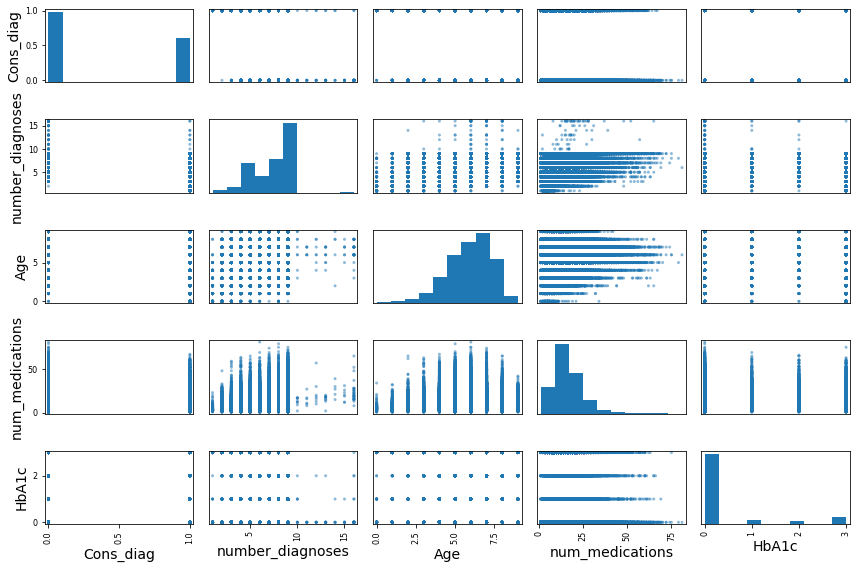

In [0]:
attributes = ["Cons_diag", "number_diagnoses", "Age", "num_medications", "HbA1c"]
scatter_matrix(diabetic_num[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [0]:
corr_matrix["re_ad"].sort_values(ascending=False)

re_ad                       1.000000
number_inpatient            0.099237
discharge_disposition_id    0.057583
time_in_hospital            0.053531
Age                         0.042717
number_diagnoses            0.041741
num_medications             0.034204
num_lab_procedures          0.028875
number_emergency            0.028249
number_outpatient           0.008659
patient_nbr                 0.004590
admission_source_id         0.004146
admission_type_id          -0.000619
num_procedures             -0.001392
Race                       -0.002100
Gender                     -0.002332
Cons_diag                  -0.007960
HbA1c                      -0.008593
Change                     -0.015996
DiabetesMed                -0.028916
encounter_id               -0.046924
Name: re_ad, dtype: float64

The columns with the highese correlation to "re_ad" is "number_inpatient", but the correlation is pretty low.

# Random Forrest Classifier Model

In [0]:
train_set, test_set = split_train_test(diabetic_num, 0.2)
len(train_set)

57215

In [0]:
train_set.shape

(57215, 21)

In [0]:
diabetic_train = train_set.drop("Cons_diag", axis=1) # drop labels for training set
diabetic_train = diabetic_train.drop("re_ad", axis=1)
dia_labels_diag = train_set["Cons_diag"].copy()
dia_labels_read = train_set["re_ad"].copy()

In [0]:
test_labels_diag = test_set["Cons_diag"].copy()
test_labels_read = test_set["re_ad"].copy()
diabetic_test = test_set.drop("Cons_diag", axis=1) # drop labels for testing set
diabetic_test = diabetic_test.drop("re_ad", axis=1)

In [0]:
diabetic_train.shape

(57215, 19)

In [0]:
diabetic_test.shape

(14303, 19)

Scaling the data.

In [0]:
dia_tr = num_pipeline.fit_transform(train_set)

In [0]:
dia_te = num_pipeline.fit_transform(test_set)

Train a Random Forest classifier on the dataset 

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [0]:
import time
t0 = time.time()
rnd_clf.fit(dia_tr, dia_labels_diag)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.17s


Accuracy score for predicting diagnoses of diabetes.

In [0]:
from sklearn.metrics import accuracy_score
dia_pred = rnd_clf.predict(dia_te)
accuracy_score(test_labels_diag, dia_pred)

1.0

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels_diag, dia_pred)

array([[8771,    0],
       [   0, 5532]])

In [0]:
from sklearn.metrics import precision_score, recall_score
precision_score(test_labels_diag, dia_pred)

1.0

In [0]:
recall_score(test_labels_diag, dia_pred)

1.0

Accuracy score for predicting re-admitted.

In [0]:
rnd_clf.fit(dia_tr, dia_labels_read)
read_pred = rnd_clf.predict(dia_te)
accuracy_score(test_labels_read, read_pred)

1.0

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, read_pred)

array([[13053,     0],
       [    0,  1250]])

In [0]:
precision_score(test_labels_read, read_pred)

1.0

In [0]:
recall_score(test_labels_read, read_pred)

1.0

Let's try using k-cross validation.

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf, dia_tr, dia_labels_diag, cv=5, scoring="accuracy")

array([1., 1., 1., 1., 1.])

In [0]:
cross_val_score(rnd_clf, dia_tr, dia_labels_read, cv=5, scoring="accuracy")

array([1., 1., 1., 1., 1.])

# SVM Model

# Linear Kernel

In [0]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svm_clf = Pipeline([("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),])
svm_clf.fit(dia_tr, dia_labels_diag)


Pipeline(memory=None,
         steps=[('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_dia_pred = svm_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_diag, svm_dia_pred)

1.0

In [0]:
cross_val_score(svm_clf, dia_tr, dia_labels_diag, cv=5, scoring="accuracy")

array([1., 1., 1., 1., 1.])

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
confusion_matrix(test_labels_diag, svm_dia_pred)

array([[8771,    0],
       [   0, 5532]])

In [0]:
precision_score(test_labels_diag, svm_dia_pred)

1.0

In [0]:
recall_score(test_labels_diag, svm_dia_pred)

1.0

In [0]:
svm_clf.fit(dia_tr, dia_labels_read)
svm_read_pred = svm_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_read, svm_read_pred)

1.0

In [0]:
cross_val_score(svm_clf, dia_tr, dia_labels_read, cv=5, scoring="accuracy")

array([1., 1., 1., 1., 1.])

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, svm_read_pred)

array([[13053,     0],
       [    0,  1250]])

In [0]:
precision_score(test_labels_read, svm_read_pred)

1.0

In [0]:
recall_score(test_labels_read, svm_read_pred)

1.0

Let's using SGDClassifier.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(dia_tr, dia_labels_diag)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
sgd_dia_pred =sgd_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_diag, sgd_dia_pred)

1.0

In [0]:
confusion_matrix(test_labels_diag, sgd_dia_pred)

array([[8771,    0],
       [   0, 5532]])

In [0]:
precision_score(test_labels_diag, sgd_dia_pred)

1.0

In [0]:
recall_score(test_labels_diag, sgd_dia_pred)

1.0

In [0]:
sgd_clf.fit(dia_tr, dia_labels_read)
sgd_read_pred =sgd_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_read, sgd_read_pred)

1.0

In [0]:
confusion_matrix(test_labels_read, sgd_read_pred)

array([[13053,     0],
       [    0,  1250]])

In [0]:
precision_score(test_labels_read, sgd_read_pred)

1.0

In [0]:
recall_score(test_labels_read, sgd_read_pred)

1.0

# Non-linear Kernel

In [0]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

In [0]:
polynomial_svm_clf.fit(dia_tr, dia_labels_diag)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_poly_dia_pred = polynomial_svm_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_diag, svm_poly_dia_pred)

1.0

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
confusion_matrix(test_labels_diag, svm_poly_dia_pred)

array([[8771,    0],
       [   0, 5532]])

In [0]:
precision_score(test_labels_diag, svm_poly_dia_pred)

1.0

In [0]:
recall_score(test_labels_diag, svm_poly_dia_pred)

1.0

In [0]:
polynomial_svm_clf.fit(dia_tr, dia_labels_read)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_poly_read_pred = polynomial_svm_clf.predict(dia_te)

In [0]:
accuracy_score(test_labels_read, svm_poly_read_pred)

1.0

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, svm_poly_read_pred)

array([[13053,     0],
       [    0,  1250]])

In [0]:
precision_score(test_labels_read, svm_poly_read_pred)

1.0

In [0]:
recall_score(test_labels_read, svm_poly_read_pred)

1.0